In [5]:
import os
from random import shuffle
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

BATCH_SIZE = 256
EPOCH = 30

train_transform = transforms.Compose(
    [transforms.Resize([64,64]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop(52),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)

val_transform = transforms.Compose(
    [transforms.Resize([64,64]),
    transforms.RandomCrop(52),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)

data_dir = 'splitted'

train_dataset = ImageFolder(root = 'splitted/train', transform=train_transform)
val_dataset = ImageFolder(root = 'splitted/val',  transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = 4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = 4)

train_dataset_size = len(train_dataset)
val_dataset_size = len(val_dataset)

class_names = train_dataset.class_to_idx

In [23]:
from torchvision import models
from torch.optim import lr_scheduler

resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 33)
resnet = resnet.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# 전체의 모델 파라미터를 업데이트 하는 것이 아니라 어느정도는 Freeze시키고 일부만 업데이트 할 것이기 때문에, 
# 업데이트를 진행하겠다는 의미인 (한 레이어.requeres_grad == True) 이면 그 레이어는 업데이터를 진행하겠다는 것임
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr = 0.001)
# SteoKR은 Epoch에 따라 Learning Rate를 변경하는 역할을 수행함
# 아래 예시에서 step_size = 7, gamma = 0.1은 7 epoch마다 0.1씩 곱해서 LR을 감소시킨다는 의미임
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [24]:
ct = 0
for child in resnet.children() :
    ct += 1
    if ct < 6 :
        for param in child.parameters() :
            param.requires_grad = False

In [25]:
import copy

def train_resnet(model, criterion, optimizer, scheduler, num_epochs=25) :
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs) : 
        print('-----epoch {}-----'.format(epoch+1))

        model.train()

        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_dataloader :
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            optimizer.zero_grad()

            output = model(inputs)
            t_loss = F.cross_entropy(output, labels)
            train_loss += t_loss.item()
            pred = output.max(1, keepdim=True)[1]
            train_corrects += pred.eq(labels.view_as(pred)).sum().item()

            t_loss.backward()
            optimizer.step()
            
        scheduler.step()
        l_r = [x['lr'] for x in optimizer.param_groups]
        print('learning rate : ', l_r)

        train_loss /= len(train_dataloader.dataset)
        train_acc = 100.0 * train_corrects / len(train_dataloader.dataset)
        print('train loss : ' + str(train_loss))
        print('train accuracy : ' + str(train_acc))

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad() :
            for inputs, labels in val_dataloader :
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                output = model(inputs)
                val_loss += F.cross_entropy(output, labels, reduction='sum').item()
                pred = output.max(1, keepdim = True)[1]
                val_corrects += pred.eq(labels.view_as(pred)).sum().item()
        
        val_loss /= len(val_dataloader.dataset)
        val_corrects = 100.0 * val_corrects / len(val_dataloader.dataset)

        print('val loss : ' + str(val_loss))
        print('val accuracy : ' + str(val_corrects))

        if val_corrects > best_acc :
            best_acc = val_corrects
            best_model_wts = copy.deepcopy(model.state_dict())

    print('best accuracy using val data : ' + str(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [26]:
model_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH)

torch.save(model_resnet50, 'resnet50.pt')

-----epoch 1-----
learning rate :  [0.001]
train loss : 0.002366769523269572
train accuracy : 81.92921755804744
val loss : 0.34442966717595763
val accuracy : 84.87920891225436
-----epoch 2-----
learning rate :  [0.001]
train loss : 0.0009169644737527899
train accuracy : 92.642461128017
val loss : 0.3190306846035155
val accuracy : 92.10163975466266
-----epoch 3-----
learning rate :  [0.001]
train loss : 0.0006222518243166121
train accuracy : 94.7892784192755
val loss : 0.07888144870203687
val accuracy : 97.85955689072475
-----epoch 4-----
learning rate :  [0.001]
train loss : 0.0004917685225269914
train accuracy : 95.91062570344741
val loss : 0.05953955656298261
val accuracy : 97.97221179121291
-----epoch 5-----
learning rate :  [0.001]
train loss : 0.00046384725572939754
train accuracy : 96.21493184376172
val loss : 0.132528534608813
val accuracy : 94.04180748529228
-----epoch 6-----
learning rate :  [0.001]
train loss : 0.00037864376504114427
train accuracy : 96.95277001959231
val los

test loss : 0.01773111617882987
test accuracy : 99.39917386406309


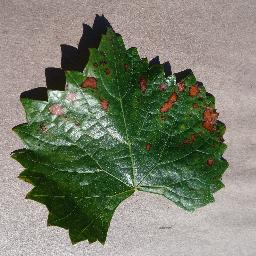

real class : Grape___Esca_(Black_Measles)
pred clss : Grape___Esca_(Black_Measles)


In [30]:
from PIL import Image

test_dataset = ImageFolder(root='splitted/test', transform=val_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle=True)

test_loss = 0.0
test_corrects = 0

with torch.no_grad() :
    for inputs, labels in test_loader :
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        output = model_resnet50(inputs)
        test_loss += F.cross_entropy(output, labels, reduction='sum').item()
        pred = output.max(1, keepdim = True)[1]
        test_corrects += pred.eq(labels.view_as(pred)).sum().item()
        
test_loss /= len(test_loader.dataset)
test_corrects = 100.0 * test_corrects / len(test_loader.dataset)

print('test loss : ' + str(test_loss))
print('test accuracy : ' + str(test_corrects))

image = Image.open('splitted/test/Grape___Esca_(Black_Measles)/image (80).JPG')
display(image)

print('real class : Grape___Esca_(Black_Measles)')

image = val_transform(image)
image = image.reshape(1,3,52,52)
image = image.cuda()

pred_prob = model_resnet50(image)
pred = pred_prob.max(1, keepdim=True)[1]

reverse_cls = {v:k for k,v in class_names.items()}
print('pred clss : ' + reverse_cls[pred.item()])


In [15]:
# resnet.children() -> (conv1, bn1, .. , layar1, .. , fc) -> 10개
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
prin